# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [5]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [6]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [7]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def centroid_undersampling(data):
    '''Faz o undersampling pegando as amostras do centro do cluster
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    centrounder = ClusterCentroids(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = centrounder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = centrounder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [8]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [9]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = centroid_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [10]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 126, 1.0: 126})
Counter({0.0: 63, 1.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [12]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [13]:
learnRate = 0.001
graficoName = "centroid-0.001-"

## RNA 1 (3)

In [14]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso
early_stopping = EarlyStopping(monitor='val_loss', patience=50) #para que não corra o risco de decorar os dados
history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping], validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5880 - acc: 0.5000 - val_loss: 1.3863 - val_acc: 0.4603
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5750 - acc: 0.5040 - val_loss: 1.3459 - val_acc: 0.4683
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5629 - acc: 0.5119 - val_loss: 1.3073 - val_acc: 0.4683
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5508 - acc: 0.5198 - val_loss: 1.2725 - val_acc: 0.4683
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.5392 - acc: 0.5198 - val_loss: 1.2391 - val_acc: 0.4683
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.5278 - acc: 0.5238 - val_loss: 1.2070 - val_acc: 0.4683
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.5167 - acc: 0.5238 - val_loss: 1.1752 - val_acc: 0.4762
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.5053 - acc

252/252 [==============================] - 0s - loss: 0.1575 - acc: 0.7778 - val_loss: 0.2671 - val_acc: 0.7460
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1572 - acc: 0.7817 - val_loss: 0.2661 - val_acc: 0.7460
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1569 - acc: 0.7857 - val_loss: 0.2651 - val_acc: 0.7460
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1566 - acc: 0.7857 - val_loss: 0.2641 - val_acc: 0.7460
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1563 - acc: 0.7817 - val_loss: 0.2633 - val_acc: 0.7460
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1560 - acc: 0.7817 - val_loss: 0.2623 - val_acc: 0.7460
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1557 - acc: 0.7817 - val_loss: 0.2615 - val_acc: 0.7460
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1554 - acc: 0.7857 - val_loss: 0.2606 - val_acc: 0.7460

252/252 [==============================] - 0s - loss: 0.1374 - acc: 0.7976 - val_loss: 0.2120 - val_acc: 0.7857
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.1373 - acc: 0.8016 - val_loss: 0.2118 - val_acc: 0.7857
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.1372 - acc: 0.7976 - val_loss: 0.2116 - val_acc: 0.7857
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.1372 - acc: 0.7976 - val_loss: 0.2114 - val_acc: 0.7857
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.1371 - acc: 0.7976 - val_loss: 0.2112 - val_acc: 0.7857
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.1370 - acc: 0.7976 - val_loss: 0.2110 - val_acc: 0.7857
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.1369 - acc: 0.8016 - val_loss: 0.2108 - val_acc: 0.7857
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.1368 - acc: 0.8016 - val_loss: 0.2106 - val_acc: 0.7857

252/252 [==============================] - 0s - loss: 0.1286 - acc: 0.8135 - val_loss: 0.1935 - val_acc: 0.8254
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.1286 - acc: 0.8175 - val_loss: 0.1934 - val_acc: 0.8254
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.1285 - acc: 0.8175 - val_loss: 0.1933 - val_acc: 0.8254
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.1285 - acc: 0.8175 - val_loss: 0.1932 - val_acc: 0.8254
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.1284 - acc: 0.8254 - val_loss: 0.1931 - val_acc: 0.8254
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.1284 - acc: 0.8254 - val_loss: 0.1930 - val_acc: 0.8254
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.1284 - acc: 0.8254 - val_loss: 0.1929 - val_acc: 0.8254
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.1283 - acc: 0.8254 - val_loss: 0.1928 - val_acc: 0.8254

252/252 [==============================] - 0s - loss: 0.1231 - acc: 0.8333 - val_loss: 0.1814 - val_acc: 0.8254
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.1231 - acc: 0.8333 - val_loss: 0.1813 - val_acc: 0.8254
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.1230 - acc: 0.8333 - val_loss: 0.1812 - val_acc: 0.8254
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.1230 - acc: 0.8333 - val_loss: 0.1811 - val_acc: 0.8254
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.1229 - acc: 0.8333 - val_loss: 0.1811 - val_acc: 0.8254
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.1230 - acc: 0.8333 - val_loss: 0.1810 - val_acc: 0.8254
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.1229 - acc: 0.8333 - val_loss: 0.1809 - val_acc: 0.8254
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.1229 - acc: 0.8333 - val_loss: 0.1808 - val_acc: 0.8254

252/252 [==============================] - 0s - loss: 0.1189 - acc: 0.8492 - val_loss: 0.1717 - val_acc: 0.8492
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.1189 - acc: 0.8492 - val_loss: 0.1716 - val_acc: 0.8492
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.1189 - acc: 0.8492 - val_loss: 0.1715 - val_acc: 0.8492
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.1188 - acc: 0.8492 - val_loss: 0.1715 - val_acc: 0.8492
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.1188 - acc: 0.8492 - val_loss: 0.1714 - val_acc: 0.8492
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.1188 - acc: 0.8492 - val_loss: 0.1713 - val_acc: 0.8492
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.1187 - acc: 0.8492 - val_loss: 0.1713 - val_acc: 0.8492
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.1187 - acc: 0.8492 - val_loss: 0.1712 - val_acc: 0.8492

252/252 [==============================] - 0s - loss: 0.1153 - acc: 0.8571 - val_loss: 0.1672 - val_acc: 0.8492
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.1153 - acc: 0.8571 - val_loss: 0.1672 - val_acc: 0.8492
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.1152 - acc: 0.8571 - val_loss: 0.1671 - val_acc: 0.8492
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.1152 - acc: 0.8571 - val_loss: 0.1671 - val_acc: 0.8492
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.1152 - acc: 0.8571 - val_loss: 0.1670 - val_acc: 0.8492
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.1152 - acc: 0.8571 - val_loss: 0.1670 - val_acc: 0.8492
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.1151 - acc: 0.8571 - val_loss: 0.1670 - val_acc: 0.8492
Epoch 776/2000
252/252 [==============================] - ETA: 0s - loss: 0.1203 - acc: 0.875 - 0s - loss: 0.1151 - acc: 0.857

252/252 [==============================] - 0s - loss: 0.1113 - acc: 0.8571 - val_loss: 0.1618 - val_acc: 0.8571
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8571 - val_loss: 0.1618 - val_acc: 0.8571
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8571 - val_loss: 0.1617 - val_acc: 0.8571
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8571 - val_loss: 0.1617 - val_acc: 0.8571
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8571 - val_loss: 0.1617 - val_acc: 0.8571
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8571 - val_loss: 0.1616 - val_acc: 0.8571
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8571 - val_loss: 0.1616 - val_acc: 0.8571
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8571 - val_loss: 0.1616 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8690 - val_loss: 0.1599 - val_acc: 0.8571
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8690 - val_loss: 0.1599 - val_acc: 0.8571
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8651 - val_loss: 0.1599 - val_acc: 0.8571
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8690 - val_loss: 0.1598 - val_acc: 0.8571
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8690 - val_loss: 0.1598 - val_acc: 0.8571
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8651 - val_loss: 0.1598 - val_acc: 0.8571
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.1096 - acc: 0.8690 - val_loss: 0.1598 - val_acc: 0.8571
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.1096 - acc: 0.8651 - val_loss: 0.1597 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.1075 - acc: 0.8651 - val_loss: 0.1578 - val_acc: 0.8571
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.1075 - acc: 0.8651 - val_loss: 0.1578 - val_acc: 0.8571
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.1074 - acc: 0.8651 - val_loss: 0.1578 - val_acc: 0.8571
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.1075 - acc: 0.8651 - val_loss: 0.1578 - val_acc: 0.8571
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.1074 - acc: 0.8651 - val_loss: 0.1578 - val_acc: 0.8571
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.1074 - acc: 0.8651 - val_loss: 0.1578 - val_acc: 0.8571
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.1074 - acc: 0.8651 - val_loss: 0.1578 - val_acc: 0.8571
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.1074 - acc: 0.8651 - val_loss: 0.1577 - val_acc:

252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8651 - val_loss: 0.1562 - val_acc: 0.8571
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8651 - val_loss: 0.1561 - val_acc: 0.8571
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8651 - val_loss: 0.1561 - val_acc: 0.8571
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.1058 - acc: 0.8651 - val_loss: 0.1561 - val_acc: 0.8571
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8651 - val_loss: 0.1561 - val_acc: 0.8571
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8651 - val_loss: 0.1561 - val_acc: 0.8571
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8651 - val_loss: 0.1561 - val_acc: 0.8571
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.1057 - acc: 0.8651 - val_loss: 0.1561 - val_acc:

252/252 [==============================] - 0s - loss: 0.1044 - acc: 0.8690 - val_loss: 0.1539 - val_acc: 0.8651
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.1044 - acc: 0.8690 - val_loss: 0.1539 - val_acc: 0.8651
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.1044 - acc: 0.8690 - val_loss: 0.1539 - val_acc: 0.8651
Epoch 1346/2000
252/252 [==============================] - ETA: 0s - loss: 0.1859 - acc: 0.781 - 0s - loss: 0.1044 - acc: 0.8690 - val_loss: 0.1539 - val_acc: 0.8651
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.1044 - acc: 0.8690 - val_loss: 0.1538 - val_acc: 0.8651
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.1044 - acc: 0.8690 - val_loss: 0.1538 - val_acc: 0.8651
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.1043 - acc: 0.8690 - val_loss: 0.1538 - val_acc: 0.8651
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.1043 - acc

252/252 [==============================] - 0s - loss: 0.1031 - acc: 0.8690 - val_loss: 0.1524 - val_acc: 0.8730
Epoch 1471/2000
252/252 [==============================] - 0s - loss: 0.1031 - acc: 0.8690 - val_loss: 0.1524 - val_acc: 0.8730
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1524 - val_acc: 0.8730
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1524 - val_acc: 0.8730
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1524 - val_acc: 0.8730
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1524 - val_acc: 0.8730
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1524 - val_acc: 0.8730
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.1030 - acc: 0.8690 - val_loss: 0.1524 - val_acc:

In [15]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1088/1962 [===============>..............] - ETA: 0s[0.075442036387874209, 0.91590214067278286]


<IPython.core.display.Javascript object>


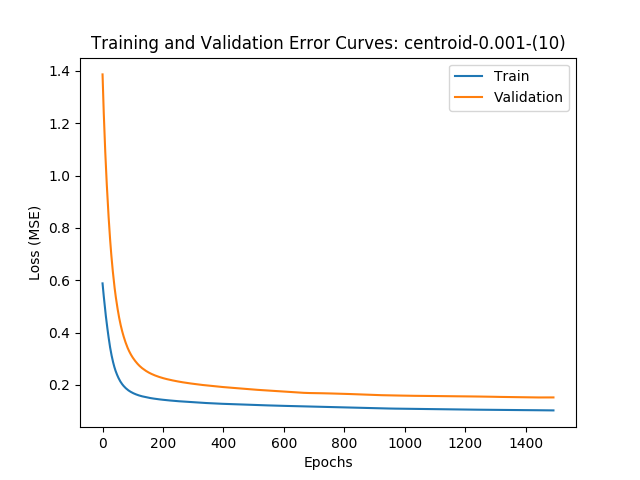

<IPython.core.display.Javascript object>


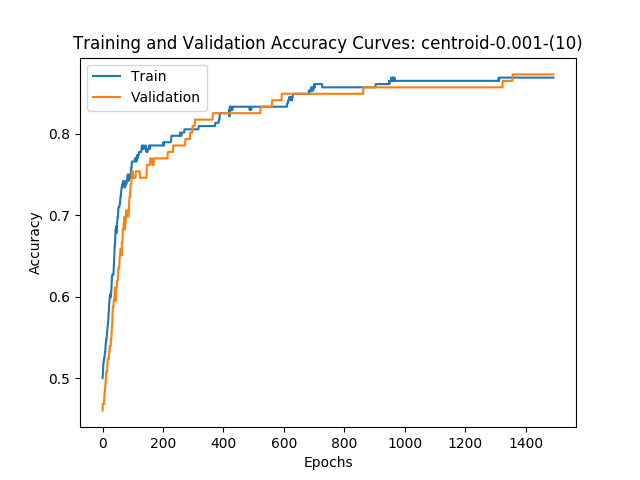

Matriz de confusão
[[1724  174]
 [   7   57]]

Train Loss:       0.1034
Validation Loss:  0.1522
Accuracy:         0.9077
MSE:              0.0923
AUROC:            0.9500


In [15]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (5)

In [14]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
early_stopping = EarlyStopping(monitor='val_loss', patience=50) 
sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping],validation_data=(X_validation, y_validation))

In [27]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.089438397448726392, 0.87869520903119736]


<IPython.core.display.Javascript object>


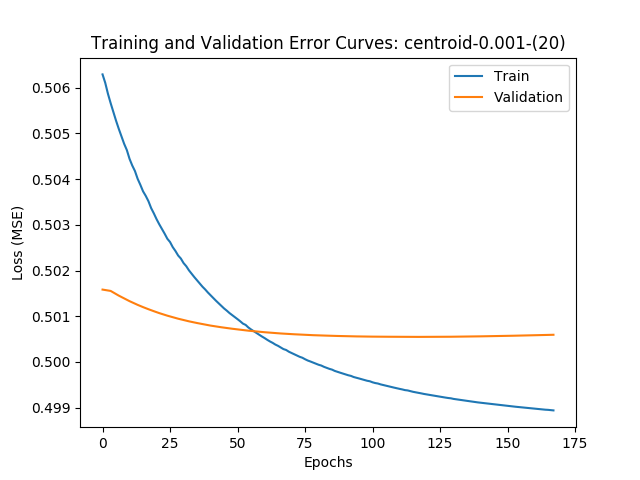

<IPython.core.display.Javascript object>


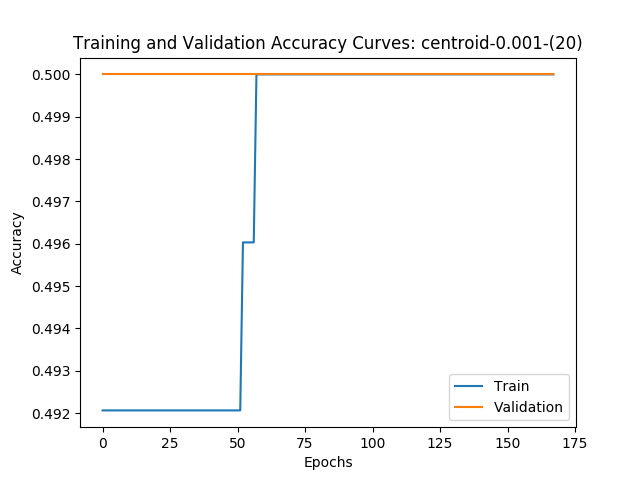

Matriz de confusão
[[1898    0]
 [  64    0]]

Train Loss:       0.4993
Validation Loss:  0.5005
Accuracy:         0.9674
MSE:              0.0326
AUROC:            0.4855


In [15]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [16]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

early_stopping = EarlyStopping(monitor='val_loss', patience=20) 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping],validation_data=(X_validation, y_validation))

In [31]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1440/1962 [=====================>........] - ETA: 0s[0.072291966765989896, 0.89857288481141695]


<IPython.core.display.Javascript object>


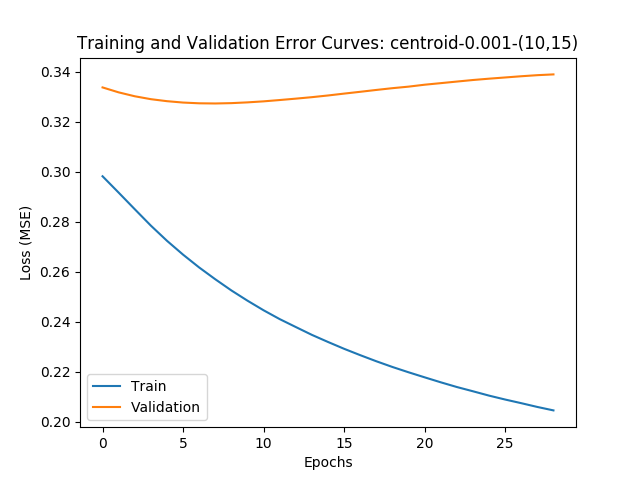

<IPython.core.display.Javascript object>


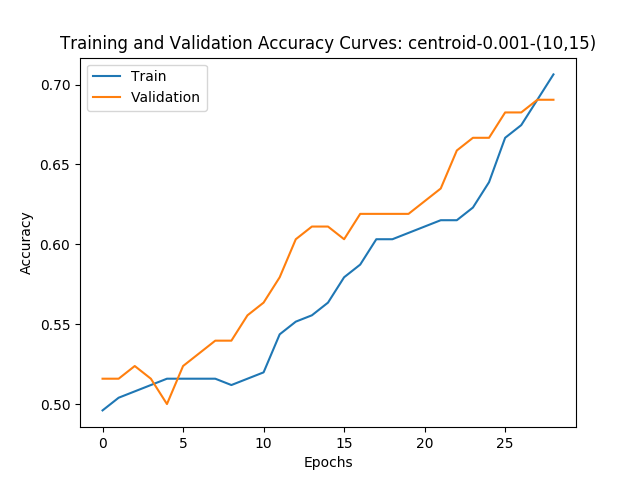

Matriz de confusão
[[1410  488]
 [  15   49]]

Train Loss:       0.2570
Validation Loss:  0.3273
Accuracy:         0.7436
MSE:              0.2564
AUROC:            0.7964


In [17]:
plot_training_error_curves(history, graficoName + "(10,15)")
plot_training_acc_curves(history, graficoName + "(10,15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (5,3)

In [18]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         callbacks=[early_stopping],validation_data=(X_validation, y_validation))

In [36]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.082341598458853943, 0.87155963308828199]


<IPython.core.display.Javascript object>


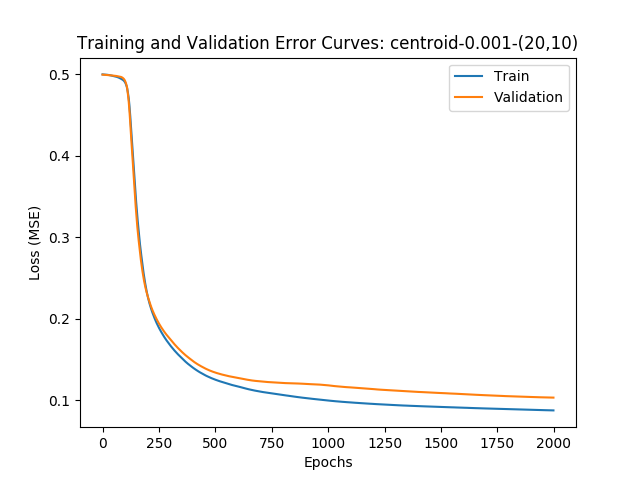

<IPython.core.display.Javascript object>


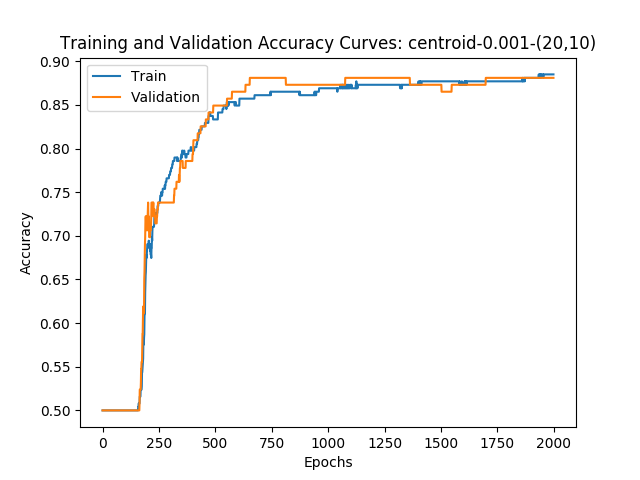

Matriz de confusão
[[1732  166]
 [   7   57]]

Train Loss:       0.0876
Validation Loss:  0.1033
Accuracy:         0.9118
MSE:              0.0882
AUROC:            0.9575


In [19]:
plot_training_error_curves(history, "centroid-0.001-(20,10)")
plot_training_acc_curves(history, "centroid-0.001-(20,10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [41]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4959 - acc: 0.5000 - val_loss: 0.4975 - val_acc: 0.4921
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4940 - acc: 0.5000 - val_loss: 0.4955 - val_acc: 0.4921
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4918 - acc: 0.5000 - val_loss: 0.4932 - val_acc: 0.4921
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4893 - acc: 0.5000 - val_loss: 0.4903 - val_acc: 0.4841
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4859 - acc: 0.4960 - val_loss: 0.4859 - val_acc: 0.4841
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4813 - acc: 0.4960 - val_loss: 0.4798 - val_acc: 0.4841
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4746 - acc: 0.4960 - val_loss: 0.4718 - val_acc: 0.4841
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4651 - acc

252/252 [==============================] - 0s - loss: 0.1108 - acc: 0.8929 - val_loss: 0.1806 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1105 - acc: 0.8929 - val_loss: 0.1805 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1103 - acc: 0.8929 - val_loss: 0.1805 - val_acc: 0.8651
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1101 - acc: 0.8929 - val_loss: 0.1801 - val_acc: 0.8651
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1099 - acc: 0.8929 - val_loss: 0.1801 - val_acc: 0.8651
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8929 - val_loss: 0.1804 - val_acc: 0.8651
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1095 - acc: 0.8929 - val_loss: 0.1803 - val_acc: 0.8651
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1093 - acc: 0.8929 - val_loss: 0.1805 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8968 - val_loss: 0.1683 - val_acc: 0.8730
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8968 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8968 - val_loss: 0.1686 - val_acc: 0.8730
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8968 - val_loss: 0.1688 - val_acc: 0.8730
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8968 - val_loss: 0.1692 - val_acc: 0.8730
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8968 - val_loss: 0.1688 - val_acc: 0.8730
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0974 - acc: 0.8968 - val_loss: 0.1685 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8968 - val_loss: 0.1683 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.8849 - val_loss: 0.1601 - val_acc: 0.8730
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8889 - val_loss: 0.1607 - val_acc: 0.8730
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8889 - val_loss: 0.1606 - val_acc: 0.8730
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8889 - val_loss: 0.1605 - val_acc: 0.8730
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1606 - val_acc: 0.8730
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1608 - val_acc: 0.8730
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1607 - val_acc: 0.8730
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0929 - acc: 0.8889 - val_loss: 0.1610 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1584 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1589 - val_acc: 0.8651
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1587 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8929 - val_loss: 0.1594 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8929 - val_loss: 0.1595 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8929 - val_loss: 0.1598 - val_acc: 0.8651
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8968 - val_loss: 0.1601 - val_acc: 0.8730
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0914 - acc: 0.8968 - val_loss: 0.1600 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.9048 - val_loss: 0.1589 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.9048 - val_loss: 0.1588 - val_acc: 0.8889
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.9048 - val_loss: 0.1585 - val_acc: 0.8889
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.9008 - val_loss: 0.1584 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.9008 - val_loss: 0.1583 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.9008 - val_loss: 0.1589 - val_acc: 0.8889
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.9008 - val_loss: 0.1590 - val_acc: 0.8889
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.9008 - val_loss: 0.1595 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.8968 - val_loss: 0.1537 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1538 - val_acc: 0.8889
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1538 - val_acc: 0.8889
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1528 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1525 - val_acc: 0.8889
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1533 - val_acc: 0.8889
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1534 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1529 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1481 - val_acc: 0.8889
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1473 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9008 - val_loss: 0.1470 - val_acc: 0.8889
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1470 - val_acc: 0.8889
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9008 - val_loss: 0.1475 - val_acc: 0.8889
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1477 - val_acc: 0.8889
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1475 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0847 - acc: 0.9008 - val_loss: 0.1477 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1423 - val_acc: 0.8889
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1419 - val_acc: 0.8889
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1411 - val_acc: 0.8889
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1411 - val_acc: 0.8889
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1409 - val_acc: 0.8889
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1407 - val_acc: 0.8889
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9008 - val_loss: 0.1414 - val_acc: 0.8889
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1412 - val_acc:

252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1360 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1361 - val_acc: 0.8889
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1358 - val_acc: 0.8889
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1355 - val_acc: 0.8889
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1359 - val_acc: 0.8889
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9048 - val_loss: 0.1364 - val_acc: 0.8889
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1359 - val_acc: 0.8889
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1361 - val_acc:

252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9048 - val_loss: 0.1334 - val_acc: 0.8889
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1327 - val_acc: 0.8889
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1329 - val_acc: 0.8889
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9048 - val_loss: 0.1330 - val_acc: 0.8889
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9048 - val_loss: 0.1331 - val_acc: 0.8889
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1330 - val_acc: 0.8889
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9087 - val_loss: 0.1331 - val_acc: 0.8889
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9087 - val_loss: 0.1330 - val_acc:

252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9048 - val_loss: 0.1320 - val_acc: 0.8730
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1315 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1315 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1319 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1317 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1318 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1319 - val_acc: 0.8810
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9048 - val_loss: 0.1314 - val_acc:

252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1317 - val_acc: 0.8730
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1313 - val_acc: 0.8810
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9048 - val_loss: 0.1320 - val_acc: 0.8730
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1320 - val_acc: 0.8730
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1318 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1315 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1312 - val_acc: 0.8810
Epoch 1543/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1312 - val_acc:

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9048 - val_loss: 0.1327 - val_acc: 0.8810
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1325 - val_acc: 0.8730
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9048 - val_loss: 0.1325 - val_acc: 0.8730
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1327 - val_acc: 0.8730
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1326 - val_acc: 0.8730
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9048 - val_loss: 0.1328 - val_acc: 0.8730
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1327 - val_acc: 0.8730
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1326 - val_acc:

252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8730
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1344 - val_acc: 0.8730
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1342 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1345 - val_acc: 0.8730
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1343 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1343 - val_acc: 0.8730
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1344 - val_acc: 0.8730
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1346 - val_acc:

252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1356 - val_acc: 0.8730
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1362 - val_acc: 0.8730
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1362 - val_acc: 0.8730
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1361 - val_acc: 0.8730
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1361 - val_acc: 0.8730
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1357 - val_acc: 0.8730
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1356 - val_acc: 0.8730
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1355 - val_acc:

In [42]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.096605206772335681, 0.87971457684076526]


<IPython.core.display.Javascript object>


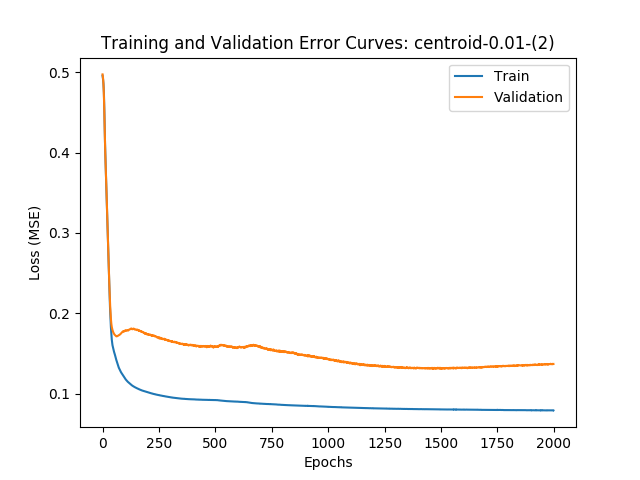

<IPython.core.display.Javascript object>


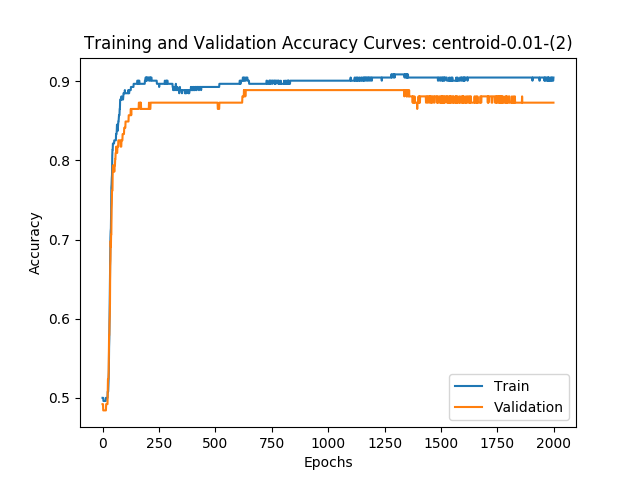

Matriz de confusão
[[1671  227]
 [   8   56]]

Train Loss:       0.0804
Validation Loss:  0.1308
Accuracy:         0.8802
MSE:              0.1198
AUROC:            0.9279


In [43]:
plot_training_error_curves(history, "centroid-0.01-(2)")
plot_training_acc_curves(history, "centroid-0.01-(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [44]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4590 - acc: 0.4563 - val_loss: 0.5013 - val_acc: 0.4762
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4406 - acc: 0.4563 - val_loss: 0.4822 - val_acc: 0.4841
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4232 - acc: 0.4563 - val_loss: 0.4639 - val_acc: 0.4841
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4060 - acc: 0.4643 - val_loss: 0.4435 - val_acc: 0.4841
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.3900 - acc: 0.4722 - val_loss: 0.4242 - val_acc: 0.4921
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.3735 - acc: 0.4722 - val_loss: 0.4048 - val_acc: 0.5079
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.3557 - acc: 0.4881 - val_loss: 0.3862 - val_acc: 0.5079
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.3372 - acc

252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8849 - val_loss: 0.1251 - val_acc: 0.8730
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8849 - val_loss: 0.1242 - val_acc: 0.8730
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8849 - val_loss: 0.1239 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8849 - val_loss: 0.1240 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8849 - val_loss: 0.1241 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8849 - val_loss: 0.1238 - val_acc: 0.8730
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8849 - val_loss: 0.1239 - val_acc: 0.8730
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8849 - val_loss: 0.1235 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8929 - val_loss: 0.1158 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.8929 - val_loss: 0.1157 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.8929 - val_loss: 0.1156 - val_acc: 0.8730
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.8929 - val_loss: 0.1155 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.8929 - val_loss: 0.1152 - val_acc: 0.8730
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.8929 - val_loss: 0.1149 - val_acc: 0.8651
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.8929 - val_loss: 0.1147 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.8929 - val_loss: 0.1144 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.8968 - val_loss: 0.1106 - val_acc: 0.8730
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.8968 - val_loss: 0.1098 - val_acc: 0.8810
Epoch 387/2000
252/252 [==============================] - ETA: 0s - loss: 0.0701 - acc: 0.968 - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1099 - val_acc: 0.8810
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1104 - val_acc: 0.8810
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.8968 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.8968 - val_loss: 0.1104 - val_acc: 0.8810
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.896

252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1090 - val_acc: 0.8810
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.8929 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.8968 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1091 - val_acc: 0.8810
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1090 - val_acc: 0.8810
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8810
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1090 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1181 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8889
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1172 - val_acc: 0.8889
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.1166 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9087 - val_loss: 0.1168 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9008 - val_loss: 0.1166 - val_acc: 0.8889
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.1162 - val_acc: 0.8889
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.1163 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1137 - val_acc: 0.8889
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.8889
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.1149 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1143 - val_acc: 0.8889
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8889
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8968
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9087 - val_loss: 0.1150 - val_acc: 0.8889
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9087 - val_loss: 0.1149 - val_acc: 0.8889
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8889
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8889
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9127 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1145 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9127 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9127 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9087 - val_loss: 0.1143 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9087 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9087 - val_loss: 0.1140 - val_acc: 0.8810
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9087 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9087 - val_loss: 0.1137 - val_acc:

252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9127 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9087 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1142 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1145 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9087 - val_loss: 0.1142 - val_acc:

252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.1150 - val_acc: 0.8810
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9087 - val_loss: 0.1153 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1155 - val_acc: 0.8730
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.1156 - val_acc: 0.8730
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1157 - val_acc: 0.8730
Epoch 1288/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9048 - val_loss: 0.1152 - val_acc:

252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9048 - val_loss: 0.1166 - val_acc: 0.8730
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9048 - val_loss: 0.1164 - val_acc: 0.8730
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8730
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9048 - val_loss: 0.1169 - val_acc: 0.8651
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1162 - val_acc: 0.8730
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8730
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8730
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.1167 - val_acc:

252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1172 - val_acc: 0.8730
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1182 - val_acc: 0.8730
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1183 - val_acc: 0.8730
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1176 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9087 - val_loss: 0.1175 - val_acc: 0.8730
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1173 - val_acc:

252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9048 - val_loss: 0.1187 - val_acc: 0.8651
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8651
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8571
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9087 - val_loss: 0.1186 - val_acc: 0.8651
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9048 - val_loss: 0.1189 - val_acc: 0.8651
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9048 - val_loss: 0.1185 - val_acc:

252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1204 - val_acc: 0.8571
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9048 - val_loss: 0.1195 - val_acc: 0.8571
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1199 - val_acc: 0.8571
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1208 - val_acc: 0.8571
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9048 - val_loss: 0.1203 - val_acc: 0.8571
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9048 - val_loss: 0.1198 - val_acc: 0.8571
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9048 - val_loss: 0.1194 - val_acc:

252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9048 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1210 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1215 - val_acc: 0.8571
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9048 - val_loss: 0.1215 - val_acc: 0.8571
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1213 - val_acc: 0.8571
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1214 - val_acc: 0.8571
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1212 - val_acc: 0.8651
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9048 - val_loss: 0.1214 - val_acc:

In [45]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.096186774312903026, 0.89551478071436363]


<IPython.core.display.Javascript object>


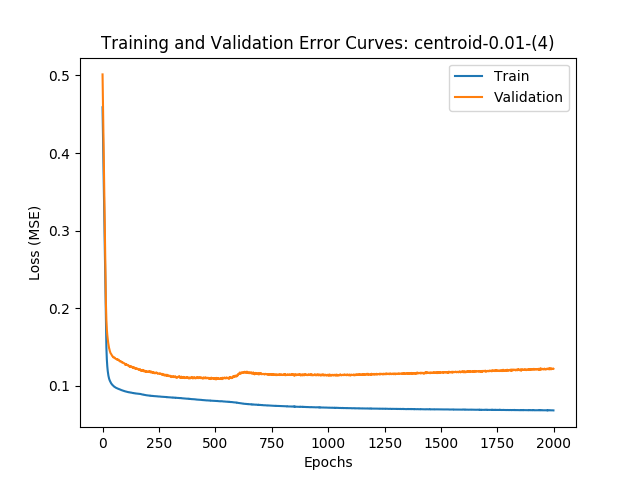

<IPython.core.display.Javascript object>


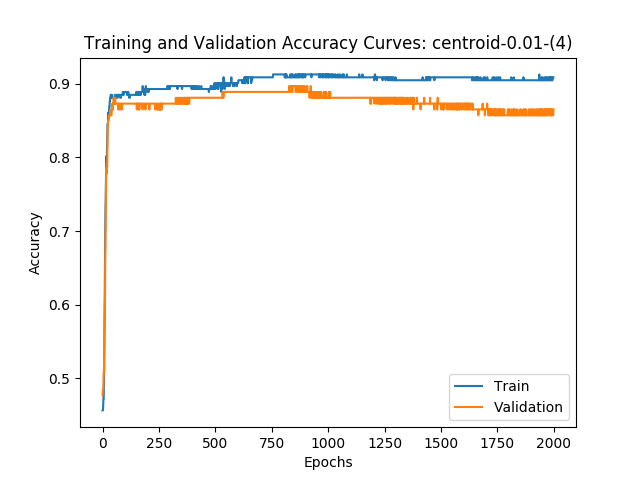

Matriz de confusão
[[1702  196]
 [   9   55]]

Train Loss:       0.0806
Validation Loss:  0.1082
Accuracy:         0.8955
MSE:              0.1045
AUROC:            0.9385


In [46]:
plot_training_error_curves(history, "centroid-0.01-(4)")
plot_training_acc_curves(history, "centroid-0.01-(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))